# Sentiment Analysis and Topics Trends over Time

In this notebook, I'll explore the topics provided by the LDA model with 12 components, which I'll reduce down to 7-8 depending on their overlap. 

Once the topics are set up, I'll take a look at how they've evolved over time and also use VADER sentiment analysis to understand the tone of the tweets of a few select topics. 

In [1]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle 

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#sklearn
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA

In [2]:
with open('../data_files/processed_tweets.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

In [3]:
df.head()

,clean,processed
0,islam kills are you trying to say that there w...,islam kill try say terrorist attack europe ref...
1,clinton trump should ve apologized more attack...,clinton trump apologize attack little
2,who was is the best president of the past year...,well president past retweet
3,i don t have to guess your religion christmasa...,guess religion christmasaftermath
4,pence and his lawyers decided which of his off...,pence lawyer decide official email public can see


## Setting up the LDA Model

In [4]:
proc_tweets = df.processed

In [5]:
vectorizer = CountVectorizer(token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True,
                             stop_words='english')

In [6]:
dtm_tf = vectorizer.fit_transform(proc_tweets)
print(dtm_tf.shape)

(203482, 77822)


Using a more thorough model with 200 iterations instead of the standard 10. This might change the topics slightly from what I saw with the pyLDAvis visualizations. 

In [7]:
%%time

lda_model = LatentDirichletAllocation(n_components=12, 
                                      random_state=42, 
                                      n_jobs=-1,
                                      max_iter=200
                                     )


lda_model.fit(dtm_tf)

lda_doc_matrix = lda_model.transform(dtm_tf)

CPU times: user 52.7 s, sys: 44.2 s, total: 1min 36s
Wall time: 14min 1s


### Setting up the 12 topics

From the LDA topics discovery notebook, I found the following 12 topics: 
1. Trump as a candidate
2. Trump's campaign
3. Police Violence
4. Clinton
5. General Twitter
6. Also Clinton
7. Conservative
8. Islam, refugees, ISIS
9. General Twitter
10. Conservative Twitter
11. General Twitter
12. German


Which could be reduced to: 
* Trump (1, 2) 
* Clinton (4, 6)
* Violence (3)
* General Twitter (5, 9, 11)
* Middle East (8)
* Conservative (7, 10)
* German (12)

I'll confirm these topics below via the top topic words, and then set up a dataframe with these labels. 

In [8]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [11]:
terms = vectorizer.get_feature_names()

display_topics(lda_model, terms, 30)


Topic  0
die, merkel, debate, muss, tonight, betteralternativetodebates, ist, watch, la, hat, debatenight, das, es, st, perfect, sie, ich, mit, den, kelly, zu, en, experience, deutschland, frau, sean, video, wird, des, carry

Topic  1
away, rejecteddebatetopics, high, todolistbeforechristmas, alternativeacronyminterpretations, political, walk, heart, listen, dear, eye, lord, obamacare, christmas, thingsnottaughtatschool, day, office, crazy, thingsthatshouldbecensored, sign, ihavearighttoknow, hold, open, fact, plan, friend, box, power, kiss, town

Topic  2
play, day, game, night, new, music, oh, make, gt, start, morning, eat, time, good, thingsyoucantignore, late, survivalguidetothanksgiving, drink, like, thingsmoretrustedthanhillary, reallifemagicspells, ruinadinnerinonephrase, makemehateyouinonephrase, minute, check, love, free, itsriskyto, song, today

Topic  3
like, look, work, way, life, say, love, want, illegal, hate, time, make, people, lose, try, hard, happen, forget, wall, pe

So looks like these topics have changed slightly: 
0. German
1. General Twitter
2. General Twitter
3. Seems general again, but with a more conservative slant -- Conservative
4. Violence
5. Clinton
6. Conservative news (pjnet)
7. Trump
8. Trump again
9. Middle East
10. Trump yet again
11. More general conservative

I'll bucket these into 8 labels: 
* Trump
* Clinton
* Conservative
* Right wing news
* Middle East
* Violence
* General Twitter
* German

### Setting up the doc-topic dataframe

In [12]:
topic_cols = ['german_1', 'general_1', 'general_2', 'gen_conservative_1', 'violence_1', 'clinton_1', 
             'conservative_news_1', 'trump_1', 'trump_2', 'middle_east_1', 'trump_3', 'gen_conservative_2']

In [13]:
lda_doc_matrix

array([[0.00833333, 0.00833341, 0.00833345, ..., 0.90833152, 0.00833345,
        0.00833376],
       [0.01388889, 0.01388889, 0.0138896 , ..., 0.18055496, 0.01388942,
        0.01389033],
       [0.02083333, 0.02083335, 0.36627754, ..., 0.02083371, 0.02083409,
        0.02083387],
       ...,
       [0.01190476, 0.01190494, 0.86904481, ..., 0.01190506, 0.01190496,
        0.01190545],
       [0.0119048 , 0.44047432, 0.01190657, ..., 0.44047319, 0.01190615,
        0.01190482],
       [0.0092593 , 0.00925978, 0.66833613, ..., 0.12329271, 0.00925961,
        0.00925929]])

In [14]:
lda_doc_matrix.shape

(203482, 12)

In [15]:
lda_df = pd.DataFrame(lda_doc_matrix, columns=topic_cols)

In [16]:
lda_df.head()

,german_1,general_1,general_2,gen_conservative_1,violence_1,clinton_1,conservative_news_1,trump_1,trump_2,middle_east_1,trump_3,gen_conservative_2
0,0.008333,0.008333,0.008333,0.008334,0.008333,0.008333,0.008333,0.008334,0.008333,0.908332,0.008333,0.008334
1,0.013889,0.013889,0.013890,0.013890,0.013890,0.378258,0.013889,0.316182,0.013889,0.180555,0.013889,0.013890
2,0.020833,0.020833,0.366278,0.020834,0.020833,0.020833,0.020834,0.425386,0.020833,0.020834,0.020834,0.020834
3,0.020833,0.020833,0.020833,0.020833,0.020833,0.020834,0.020833,0.020833,0.425387,0.366277,0.020833,0.020834
4,0.011905,0.011905,0.011905,0.011906,0.011905,0.509093,0.011905,0.214999,0.011905,0.011905,0.168762,0.011905


In [127]:
# Summing the LDA probabilitities by bucket
lda_df['trump'] = lda_df['trump_1'] + lda_df['trump_2'] + lda_df['trump_3']
lda_df['clinton'] = lda_df['clinton_1']
lda_df['general'] = lda_df['general_1'] + lda_df['general_2']
lda_df['conservative'] = lda_df['gen_conservative_1'] + lda_df['gen_conservative_2']
lda_df['right_wing_news'] = lda_df['conservative_news_1']
lda_df['violence'] = lda_df['violence_1']
lda_df['middle_east'] = lda_df['middle_east_1']
lda_df['german'] = lda_df['german_1']

In [18]:
lda_df.head()

,german_1,general_1,general_2,gen_conservative_1,violence_1,clinton_1,conservative_news_1,trump_1,trump_2,middle_east_1,trump_3,gen_conservative_2,trump,clinton,general,conservative,right_wing_news,violence,middle_east,german
0,0.008333,0.008333,0.008333,0.008334,0.008333,0.008333,0.008333,0.008334,0.008333,0.908332,0.008333,0.008334,0.025000,0.008333,0.016667,0.016668,0.008333,0.008333,0.908332,0.008333
1,0.013889,0.013889,0.013890,0.013890,0.013890,0.378258,0.013889,0.316182,0.013889,0.180555,0.013889,0.013890,0.343961,0.378258,0.027778,0.027780,0.013889,0.013890,0.180555,0.013889
2,0.020833,0.020833,0.366278,0.020834,0.020833,0.020833,0.020834,0.425386,0.020833,0.020834,0.020834,0.020834,0.467054,0.020833,0.387111,0.041668,0.020834,0.020833,0.020834,0.020833
3,0.020833,0.020833,0.020833,0.020833,0.020833,0.020834,0.020833,0.020833,0.425387,0.366277,0.020833,0.020834,0.467054,0.020834,0.041667,0.041668,0.020833,0.020833,0.366277,0.020833
4,0.011905,0.011905,0.011905,0.011906,0.011905,0.509093,0.011905,0.214999,0.011905,0.011905,0.168762,0.011905,0.395667,0.509093,0.023810,0.023811,0.011905,0.011905,0.011905,0.011905


### Bucketing the topics into 7 labels

In [19]:
topic_df = lda_df[['trump', 'clinton', 'general', 'violence', 
                   'middle_east', 'german', 'conservative', 'right_wing_news']]

In [20]:
topic_df['label'] = topic_df.idxmax(axis=1)

<ipython-input-20-d4be874da69f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_df['label'] = topic_df.idxmax(axis=1)


In [21]:
topic_df.head()

,trump,clinton,general,violence,middle_east,german,conservative,right_wing_news,label
0,0.025000,0.008333,0.016667,0.008333,0.908332,0.008333,0.016668,0.008333,middle_east
1,0.343961,0.378258,0.027778,0.013890,0.180555,0.013889,0.027780,0.013889,clinton
2,0.467054,0.020833,0.387111,0.020833,0.020834,0.020833,0.041668,0.020834,trump
3,0.467054,0.020834,0.041667,0.020833,0.366277,0.020833,0.041668,0.020833,trump
4,0.395667,0.509093,0.023810,0.011905,0.011905,0.011905,0.023811,0.011905,clinton


In [22]:
text = pd.read_csv('../data_files/tweets.csv.zip')
text.head()

,user_id,user_key,created_at,created_str,retweet_count,retweeted,favorite_count,text,tweet_id,source,hashtags,expanded_urls,posted,mentions,retweeted_status_id,in_reply_to_status_id
0,1.868981e+09,ryanmaxwell_1,1.458672e+12,2016-03-22 18:31:42,NaN,NaN,NaN,#IslamKills Are you trying to say that there w...,7.123460e+17,NaN,"[""IslamKills""]",[],POSTED,[],NaN,NaN
1,2.571870e+09,detroitdailynew,1.476133e+12,2016-10-10 20:57:00,0.0,False,0.0,"Clinton: Trump should’ve apologized more, atta...",7.855849e+17,"<a href=""http://twitterfeed.com"" rel=""nofollow...",[],"[""http://detne.ws/2e172jF""]",POSTED,[],NaN,NaN
2,1.710805e+09,cookncooks,1.487767e+12,2017-02-22 12:43:43,NaN,NaN,NaN,RT @ltapoll: Who was/is the best president of ...,8.343832e+17,NaN,[],[],POSTED,[],NaN,NaN
3,2.584153e+09,queenofthewo,1.482765e+12,2016-12-26 15:06:41,NaN,NaN,NaN,RT @jww372: I don't have to guess your religio...,8.134006e+17,NaN,"[""ChristmasAftermath""]",[],POSTED,[],NaN,NaN
4,1.768260e+09,mrclydepratt,1.501987e+12,2017-08-06 02:36:24,NaN,NaN,NaN,RT @Shareblue: Pence and his lawyers decided w...,8.940243e+17,NaN,[],[],POSTED,[],NaN,NaN


In [23]:
topic_df['handle'] = text['user_key']
topic_df['datetime'] = text['created_str']
topic_df['tweet'] = text['text']

<ipython-input-23-ef014d9c3b91>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_df['handle'] = text['user_key']
<ipython-input-23-ef014d9c3b91>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_df['datetime'] = text['created_str']
<ipython-input-23-ef014d9c3b91>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [24]:
topic_df.head()

,trump,clinton,general,violence,middle_east,german,conservative,right_wing_news,label,handle,datetime,tweet
0,0.025000,0.008333,0.016667,0.008333,0.908332,0.008333,0.016668,0.008333,middle_east,ryanmaxwell_1,2016-03-22 18:31:42,#IslamKills Are you trying to say that there w...
1,0.343961,0.378258,0.027778,0.013890,0.180555,0.013889,0.027780,0.013889,clinton,detroitdailynew,2016-10-10 20:57:00,"Clinton: Trump should’ve apologized more, atta..."
2,0.467054,0.020833,0.387111,0.020833,0.020834,0.020833,0.041668,0.020834,trump,cookncooks,2017-02-22 12:43:43,RT @ltapoll: Who was/is the best president of ...
3,0.467054,0.020834,0.041667,0.020833,0.366277,0.020833,0.041668,0.020833,trump,queenofthewo,2016-12-26 15:06:41,RT @jww372: I don't have to guess your religio...
4,0.395667,0.509093,0.023810,0.011905,0.011905,0.011905,0.023811,0.011905,clinton,mrclydepratt,2017-08-06 02:36:24,RT @Shareblue: Pence and his lawyers decided w...


In [25]:
topic_df['datetime'] = pd.to_datetime(topic_df['datetime'])
topic_df['month'] = topic_df['datetime'].dt.strftime('%Y-%m')

<ipython-input-25-b041bded2906>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_df['datetime'] = pd.to_datetime(topic_df['datetime'])
<ipython-input-25-b041bded2906>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_df['month'] = topic_df['datetime'].dt.strftime('%Y-%m')


In [26]:
topic_df.head()

,trump,clinton,general,violence,middle_east,german,conservative,right_wing_news,label,handle,datetime,tweet,month
0,0.025000,0.008333,0.016667,0.008333,0.908332,0.008333,0.016668,0.008333,middle_east,ryanmaxwell_1,2016-03-22 18:31:42,#IslamKills Are you trying to say that there w...,2016-03
1,0.343961,0.378258,0.027778,0.013890,0.180555,0.013889,0.027780,0.013889,clinton,detroitdailynew,2016-10-10 20:57:00,"Clinton: Trump should’ve apologized more, atta...",2016-10
2,0.467054,0.020833,0.387111,0.020833,0.020834,0.020833,0.041668,0.020834,trump,cookncooks,2017-02-22 12:43:43,RT @ltapoll: Who was/is the best president of ...,2017-02
3,0.467054,0.020834,0.041667,0.020833,0.366277,0.020833,0.041668,0.020833,trump,queenofthewo,2016-12-26 15:06:41,RT @jww372: I don't have to guess your religio...,2016-12
4,0.395667,0.509093,0.023810,0.011905,0.011905,0.011905,0.023811,0.011905,clinton,mrclydepratt,2017-08-06 02:36:24,RT @Shareblue: Pence and his lawyers decided w...,2017-08


In [27]:
labeled_tweets = topic_df[['month', 'handle', 'label', 'tweet']]

In [28]:
labeled_tweets

,month,handle,label,tweet
0,2016-03,ryanmaxwell_1,middle_east,#IslamKills Are you trying to say that there w...
1,2016-10,detroitdailynew,clinton,"Clinton: Trump should’ve apologized more, atta..."
2,2017-02,cookncooks,trump,RT @ltapoll: Who was/is the best president of ...
3,2016-12,queenofthewo,trump,RT @jww372: I don't have to guess your religio...
4,2017-08,mrclydepratt,clinton,RT @Shareblue: Pence and his lawyers decided w...
...,...,...,...,...
203477,2016-11,nojonathonno,clinton,"RT @AndreaChalupa: In intel circles, the story..."
203478,2015-06,judelambertusa,violence,RT @KansasCityDNews: Tonganoxie police: Middle...
203479,2017-01,patriotblake,general,RT @signsinyork: Getting the right #company lo...
203480,2016-11,dailysandiego,general,The Latest: Obama affirms continuity of ties w...


## Topic Review

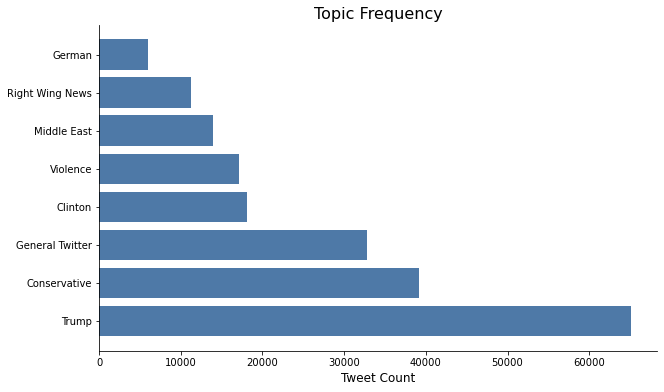

In [131]:
labels = ['Trump', 'Conservative', 'General Twitter', 'Clinton', 'Violence', 'Middle East', 
         'Right Wing News', 'German']

top_freq = list(labeled_tweets['label'].value_counts())

plt.figure(figsize=(10, 6))
plt.barh(labels, top_freq, color='#4e79a7')
plt.xlabel('Tweet Count', fontsize=12)
plt.title("Topic Frequency", fontsize=16)
sns.despine()
#plt.savefig('../img/topic_frequency.png');

Mostly Trump, followed by Conservative and General Twitter categories. 

Let's take a look at how these topics evolved over time. 

In [30]:
date_freq = labeled_tweets.groupby(['month', 'label']).size().unstack().reset_index()

In [31]:
date_freq.fillna(0, inplace=True)
date_freq['total'] = date_freq.sum(axis=1)

In [32]:
date_freq

label,month,clinton,conservative,general,german,middle_east,right_wing_news,trump,violence,total
0,2014-07,0.0,9.0,2.0,0.0,0.0,0.0,1.0,0.0,12.0
1,2014-08,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,2014-09,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2014-11,5.0,158.0,117.0,6.0,14.0,23.0,55.0,10.0,388.0
4,2014-12,6.0,217.0,90.0,3.0,11.0,26.0,74.0,15.0,442.0
5,2015-01,27.0,963.0,568.0,34.0,58.0,125.0,309.0,107.0,2191.0
6,2015-02,48.0,901.0,444.0,42.0,96.0,128.0,321.0,111.0,2091.0
7,2015-03,102.0,860.0,487.0,43.0,114.0,103.0,449.0,167.0,2325.0
8,2015-04,86.0,637.0,494.0,49.0,103.0,106.0,403.0,372.0,2250.0
9,2015-05,110.0,378.0,373.0,44.0,97.0,189.0,356.0,353.0,1900.0


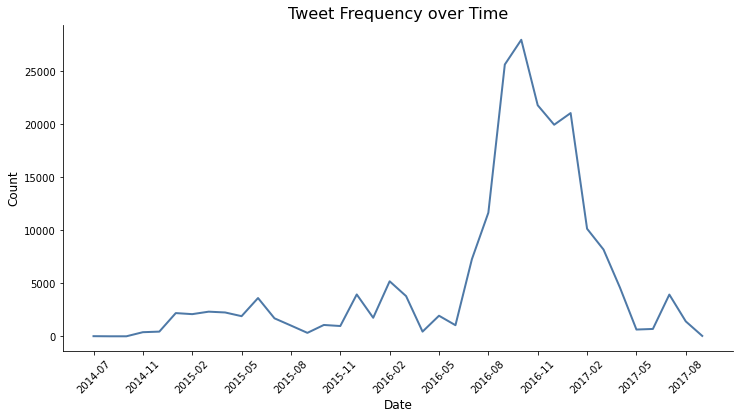

In [33]:
dates = date_freq.month
total_tweets = date_freq.total
x_ticks = list(date_freq.month.unique()[::3])

plt.figure(figsize=(12, 6))
plt.plot(dates, total_tweets, color='#4e79a7', linewidth=2)
plt.title('Tweet Frequency over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(x_ticks, rotation=45)
sns.despine();

In [34]:
date_freq.columns

Index(['month', 'clinton', 'conservative', 'general', 'german', 'middle_east',
       'right_wing_news', 'trump', 'violence', 'total'],
      dtype='object', name='label')

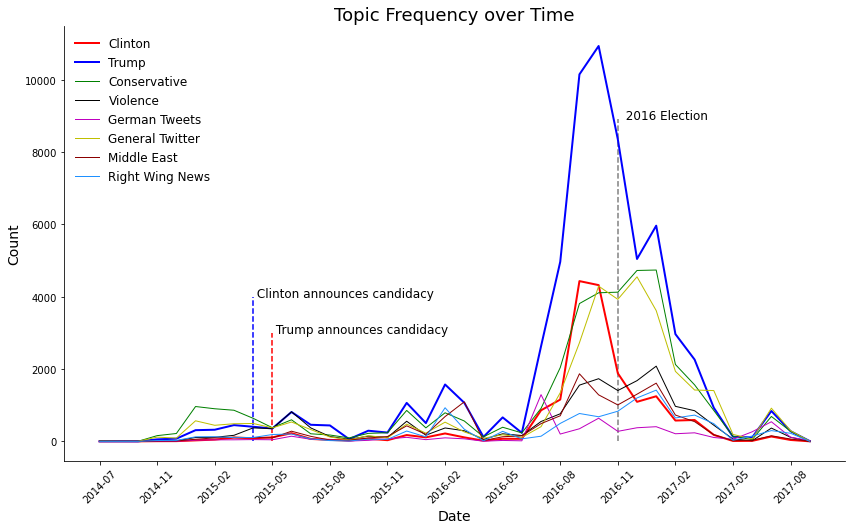

In [65]:
dates = date_freq.month
x_ticks = list(date_freq.month.unique()[::3])

clinton = date_freq.clinton
trump = date_freq.trump
conservative = date_freq.conservative
gen_twitter = date_freq.general
german = date_freq.german
middle_east = date_freq.middle_east
violence = date_freq.violence
right_wing_news = date_freq.right_wing_news


plt.figure(figsize=(14, 8))
plt.plot(dates, clinton, color='r', linewidth=2, label='Clinton')
plt.plot(dates, trump, color='b', linewidth=2, label='Trump')

plt.plot(dates, conservative, color='g', linewidth=1, label='Conservative')
plt.plot(dates, violence, color='0', linewidth=1, label='Violence')
plt.plot(dates, german, color='m', linewidth=1, label='German Tweets')
plt.plot(dates, gen_twitter, color='y', linewidth=1, label='General Twitter')
plt.plot(dates, middle_east, color='darkred', linewidth=1, label='Middle East')
plt.plot(dates, right_wing_news, color='dodgerblue', linewidth=1, label='Right Wing News')

plt.vlines('2015-04', ymin=0, ymax=4000, linestyle='--', color='b')
plt.text('2015-04', 4000, ' Clinton announces candidacy', rotation=0, fontsize=12)

plt.vlines('2015-05', ymin=0, ymax=3000, linestyle='--', color='r')
plt.text('2015-05', 3000, ' Trump announces candidacy', rotation=0, fontsize=12)

plt.vlines('2016-11', ymin=0, ymax=8900, linestyle='--', color='grey')
plt.text('2016-11', 8900, '  2016 Election', rotation=0, fontsize=12)


plt.title('Topic Frequency over Time', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(x_ticks, rotation=45)
plt.legend(loc='upper left', frameon=False, fontsize=12)
sns.despine()
#plt.savefig('../img/top_freq_timeseries.png');

This is pretty interesting - there's a slow setup time of almost two years, but once we hit June 2017, the accounts really amp up their Trump content, with smaller, but similar surges for Hillary. 

The conservative and general tweets keep shroud the overall activity in a cloud of normalcy. 

## Sentiment Analysis

Using Vader Sentiment Analysis to take a look at the tone of the tweets. 

In [37]:
def sentiment_score(text):
    analyzer = SentimentIntensityAnalyzer()
    compound_score = analyzer.polarity_scores(text)['compound']
    return compound_score

In [41]:
feels_df = labeled_tweets.copy()

In [42]:
feels_df['tweet'] = feels_df['tweet'].astype(str)

In [43]:
feels_df.head()

,month,handle,label,tweet
0,2016-03,ryanmaxwell_1,middle_east,#IslamKills Are you trying to say that there w...
1,2016-10,detroitdailynew,clinton,"Clinton: Trump should’ve apologized more, atta..."
2,2017-02,cookncooks,trump,RT @ltapoll: Who was/is the best president of ...
3,2016-12,queenofthewo,trump,RT @jww372: I don't have to guess your religio...
4,2017-08,mrclydepratt,clinton,RT @Shareblue: Pence and his lawyers decided w...


I'm batching these to reduce computational burden and because I'm mostly interested in seeing Trump and Hillary tweets.

In [44]:
trump_feels = feels_df[feels_df.label == 'trump']
trump_feels.head()

,month,handle,label,tweet
2,2017-02,cookncooks,trump,RT @ltapoll: Who was/is the best president of ...
3,2016-12,queenofthewo,trump,RT @jww372: I don't have to guess your religio...
7,2016-12,judelambertusa,trump,RT @100PercFEDUP: New post: WATCH: DIAMOND AND...
10,2017-01,jasper_fly,trump,RT @ElPenguinito: #myfarewellwordswouldbe I've...
11,2016-12,patriotblake,trump,"RT @America_1st_: CW: ""The thing that impresse..."


In [45]:
%%time
trump_feels['vader_score'] = trump_feels['tweet'].map(sentiment_score)

CPU times: user 7min 13s, sys: 6.66 s, total: 7min 20s
Wall time: 7min 20s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [46]:
trump_feels.head()

,month,handle,label,tweet,vader_score
2,2017-02,cookncooks,trump,RT @ltapoll: Who was/is the best president of ...,0.6369
3,2016-12,queenofthewo,trump,RT @jww372: I don't have to guess your religio...,0.0000
7,2016-12,judelambertusa,trump,RT @100PercFEDUP: New post: WATCH: DIAMOND AND...,0.4824
10,2017-01,jasper_fly,trump,RT @ElPenguinito: #myfarewellwordswouldbe I've...,0.0000
11,2016-12,patriotblake,trump,"RT @America_1st_: CW: ""The thing that impresse...",0.8248


In [47]:
%%time
clinton_feels = feels_df[feels_df.label == 'clinton']
clinton_feels['vader_score'] = clinton_feels['tweet'].map(sentiment_score)

CPU times: user 1min 59s, sys: 1.86 s, total: 2min 1s
Wall time: 2min 1s


<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [48]:
%%time
general_feels = feels_df[feels_df.label == 'general']
general_feels['vader_score'] = general_feels['tweet'].map(sentiment_score)

CPU times: user 4min 43s, sys: 4.5 s, total: 4min 47s
Wall time: 11min 11s


<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
clinton_feels_time = clinton_feels.groupby('month').agg({'vader_score': 'mean'}).reset_index()
trump_feels_time = trump_feels.groupby('month').agg({'vader_score': 'mean'}).reset_index()
general_feels_time = general_feels.groupby('month').agg({'vader_score': 'mean'}).reset_index()

In [134]:
# setting an even time period to take a look at

clinton_tweets = clinton_feels_time[(clinton_feels_time['month'] >= '2014-11') & 
                                    (clinton_feels_time['month'] <= '2017-07')]

trump_tweets = trump_feels_time[(trump_feels_time['month'] >= '2014-11') & 
                                (trump_feels_time['month'] <= '2017-07')]

general_tweets = general_feels_time[(general_feels_time['month'] >= '2014-11') & 
                                    (general_feels_time['month'] <= '2017-07')]

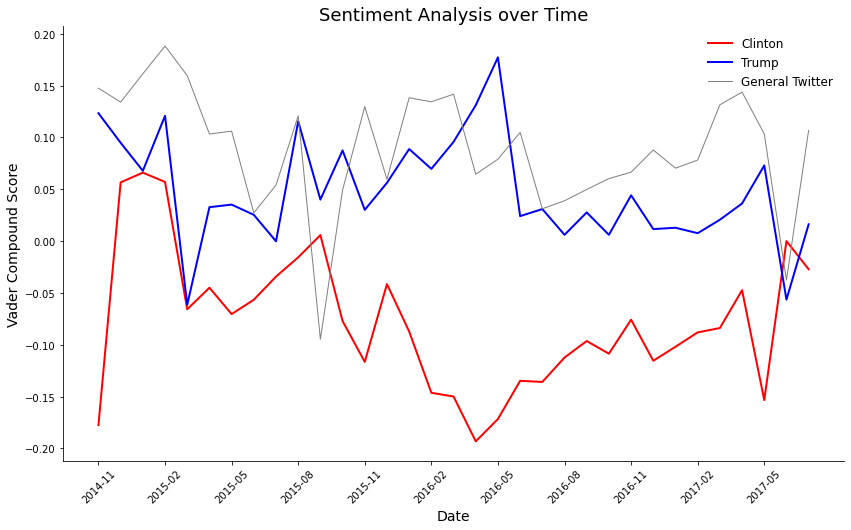

In [137]:
clinton = clinton_tweets.vader_score
trump = trump_tweets.vader_score
general = general_tweets.vader_score

x_ticks = list(general_tweets.month.unique()[::3])

plt.figure(figsize=(14, 8))
plt.plot(clinton_tweets.month, clinton, color='r', linewidth=2, label='Clinton')
plt.plot(trump_tweets.month, trump, color='b', linewidth=2, label='Trump')
plt.plot(general_tweets.month, general, color='grey', linewidth=1, label='General Twitter')


plt.title('Sentiment Analysis over Time', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Vader Compound Score', fontsize=14)
plt.xticks(x_ticks, rotation=45)
plt.legend(loc='best', frameon=False, fontsize=12)
sns.despine()
#plt.savefig('../img/sentiment_timeseries.png');

What happened to Clinton in early 2016?

In [68]:
hc_tweets = clinton_feels[(clinton_feels['month'] == '2016-03') & 
                          (clinton_feels['vader_score'] < -0.05)]

for tweet in hc_tweets.tweet[:15]:
    print(tweet, '\n')

RT @gerfingerpoken2: (IBD) Charles Woods Seeks #Benghazi Answers On Son Ty's Death https://t.co/LpLMT4J2XU  @IBDEditorials #PJNET https://t… 

Can you imagine that she called the mother of a Benghazi victim a liar?! How dare she to say so?! #HillaryForPrison https://t.co/FuTF0uF48R 

RT @ocblues: We'll give you Billions, with no strings attached. https://t.co/dJtv3Rp7Gu https://t.co/Yfz2fSrF0W 

RT @bpolitics: Hillary Clinton says it was a “terrible mistake” to give gun makers and sellers immunity https://t.co/OrS7l8Xryr https://t.c… 

RT @SenSanders: It is class warfare when the wealthy buy our elections to get tax breaks for themselves and cut spending to programs the re… 

RT @RickSanchezTV: CIA expert agrees with me on @CruzSexScandal.  Cruz lying about #CruzSexScandal
https://t.co/dWumXMN53O 

RT @gerfingerpoken: (IBD) Charles Woods Seeks #Benghazi Answers On Son Ty's Death https://t.co/2u3BpEvw0w  @IBDEditorials #PJNET https://t.… 

RT @WalshFreedom: Karl Rove is a hack and total

So not all of these are about Hillary Clinton - but a lot of them are. And seemed like the sentiment is labeled correctly. Also #CruzSexScandal.... gross. 

How about positive Trump during the same period? 

In [70]:
trump_tweets = trump_feels[(trump_feels['month'] == '2016-04') & 
                           (trump_feels['vader_score'] > 0.05)]

for tweet in trump_tweets.tweet[:15]:
    print(tweet, '\n')

RT @streiffredstate: New Super PAC Ad Uses Obama Speech To Tie John Kasich To ObamaCare https://t.co/mXYUKfY8cg via @streiffredstate 

Don't forget! California you must be registered Republican by May 23, 2016 to vote for TRUMP. 
Do it now! https://t.co/9DE2GOozuw 

The Veterans support @realDonaldTrump
#instotus #patriots https://t.co/xTntkHuz5N 

RT @AlecMacGillis: A pretty remarkable expansion of voting rights now underway in Maryland. https://t.co/PmiJrkPXi5 https://t.co/z8W6EkBlGO 

#BeingBlackIs being strong https://t.co/aYmqU2pjX4 

#BeingBlackIs fighting for freedom and equality for yourself and the loved ones 

We're all so strong https://t.co/iWUsoxetVZ 

RT @MingNa: Nothing against Scarlett Johansson. In fact, I'm a big fan. But everything against this Whitewashing of Asian role.😒 https://t.… 

RT @streiffredstate: New Super PAC Ad Uses Obama Speech To Tie John Kasich To ObamaCare https://t.co/mXYUKfY8cg via @streiffredstate 

RT @brodigan: Dear NYers,

Still whining about #

Fewer of these are about Trump as the Clinton ones were about her, but there are a couple in here rallying behind him. 

Also seeing the use of #BeingBlackIs as part of the cover is disturbing. 

## Reduced dimensions visualizations

Now I'll try PCA and TSNE to reduce the feature dimensionality down to 2-D so we can visualize the clusters. 

In [73]:
topic_df.columns

Index(['trump', 'clinton', 'general', 'violence', 'middle_east', 'german',
       'conservative', 'right_wing_news', 'label', 'handle', 'datetime',
       'tweet', 'month'],
      dtype='object')

In [74]:
doc_topic_matrix = topic_df[['trump', 'clinton', 'general', 'violence', 
                             'middle_east', 'german', 'conservative', 'right_wing_news']].values

### PCA

In [75]:
def plot_PCA(data, target, target_names, colors, title=None):
    plt.figure(figsize=(10,10), dpi=100)
    for c, label in zip(colors, target_names):
        plt.scatter(data[target == label, 0], data[target == label, 1],
                   c=c, label=label, alpha=0.5, s=.75)
    lgnd = plt.legend(fontsize=10, prop={'size':12}, loc='upper right', frameon=False)
    
    for i in range(len(target_names)):
        lgnd.legendHandles[i]._sizes = [50]
    
    if title is not None:
        plt.title(title, fontsize=16)
    
    plt.xlabel('PCA Feature 1', fontsize=12)
    plt.ylabel('PCA Feature 2', fontsize=12)
    sns.despine()
    #plt.savefig('../img/lda_pca_plot.png')
    plt.show();

In [85]:
target = topic_df['label']
target_names = list(target.unique())
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'darkred', 'dodgerblue']

In [77]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(doc_topic_matrix)

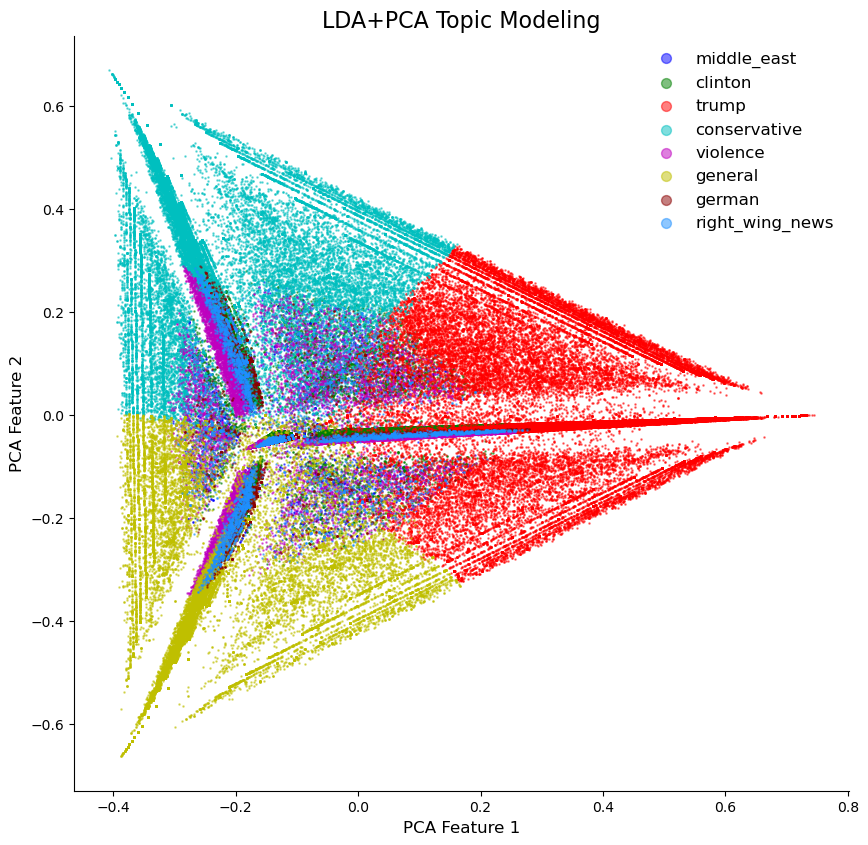

In [86]:
plot_PCA(pca_features, 
         target=target, 
         target_names=target_names, 
         colors=colors, 
         title='LDA+PCA Topic Modeling')

### TSNE

In [88]:
tsne_model = TSNE(n_components=2, 
                  perplexity=50,
                  random_state=37,
                  n_jobs=-1)

In [89]:
tsne_lda = tsne_model.fit_transform(doc_topic_matrix)

In [90]:
def plot_tsne(data, target, target_names, colors, title=None):
    
    plt.figure(figsize=(10, 8), dpi=100)
    for c, label in zip(colors, target_names):
        plt.scatter(data[target == label, 0], data[target == label, 1], c=c, label=label, s=0.5, alpha=0.6)
    lgnd = plt.legend(fontsize=10, prop={'size':12}, loc='upper right', frameon=False)
    for i in range(len(target_names)):
        lgnd.legendHandles[i]._sizes = [50]
    sns.despine()
    plt.xlim(-50, 65)
    plt.ylim(-50, 65)
    
    if title is not None:
        plt.title(title, fontsize=16)
    
    plt.xlabel("TSNE Feature 1")
    plt.ylabel("TSNE Feature 2")
    #plt.savefig('../img/lda_tsne_plot.png')
    plt.show();

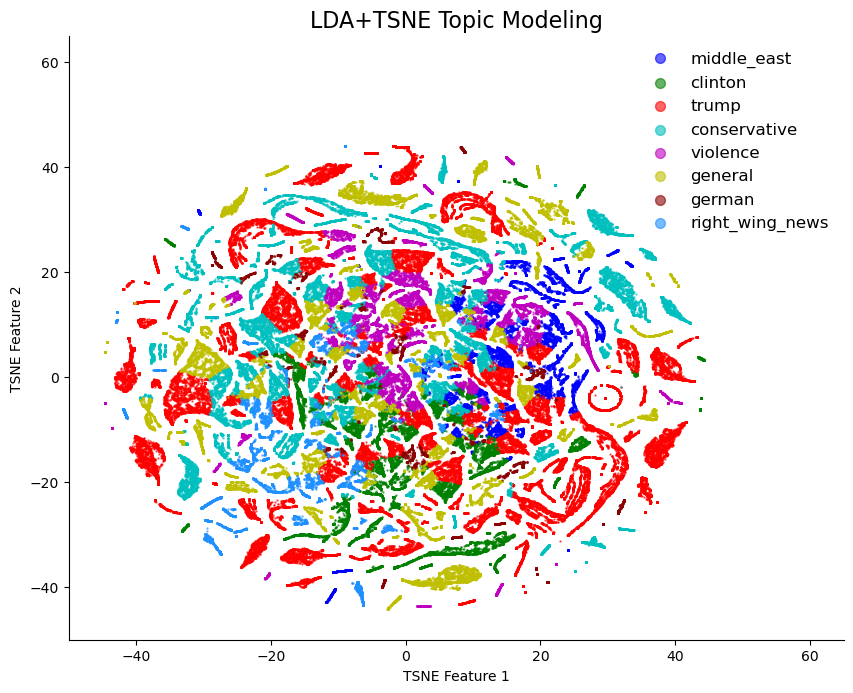

In [91]:
plot_tsne(tsne_lda, 
          target, 
          target_names, 
          colors, 
          title='LDA+TSNE Topic Modeling')

Neither of these is super interpretable but they are kind of fun to look at -- if anything, you just get a sense of the magnitude for the presence of the Trump topics. 

## Save model for more visualizations later

I'll set up some more visualizations in another notebook, including some word clouds by topic and sentiment. 

In [98]:
other_labels_df = feels_df[(feels_df['label'] == 'violence') |
                           (feels_df['label'] == 'middle_east') |
                           (feels_df['label'] == 'conservative') |
                           (feels_df['label'] == 'right_wing_news')]

In [100]:
tweets_with_labels_and_feelings = pd.concat([clinton_feels, trump_feels, general_feels, other_labels_df])

In [126]:
tweets_with_labels_and_feelings.head()

,month,handle,label,tweet,vader_score
1,2016-10,detroitdailynew,clinton,"Clinton: Trump should’ve apologized more, atta...",-0.2484
4,2017-08,mrclydepratt,clinton,RT @Shareblue: Pence and his lawyers decided w...,0.0000
13,2016-08,pamela_moore13,clinton,"Dave Chappelle: ""Black Lives Matter"" is the wo...",-0.6792
42,2017-03,paulinett,clinton,RT @KStreetHipster: Hamner-Brown is already on...,0.0000
43,2017-03,hyddrox,clinton,RT @TrumpSuperPAC: Obama's a Muslim &amp; this...,0.4184


In [102]:
# with open('../data_files/tweets_with_feels.pickle', 'wb') as to_write:
#    pickle.dump(tweets_with_labels_and_feelings, to_write)